In [1]:
import numpy as np
from tensorflow.keras.datasets import imdb
(x_train_all, y_train_all), (x_test, y_test) = imdb.load_data(skip_top=20, num_words=100)

17465344/17464789 [==============================] - 2s 0us/step


In [2]:
print(x_train_all.shape, y_train_all.shape)

(25000,) (25000,)


In [3]:
print(x_train_all[0])

[2, 2, 22, 2, 43, 2, 2, 2, 2, 65, 2, 2, 66, 2, 2, 2, 36, 2, 2, 25, 2, 43, 2, 2, 50, 2, 2, 2, 35, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 39, 2, 2, 2, 2, 2, 2, 38, 2, 2, 2, 2, 50, 2, 2, 2, 2, 2, 2, 22, 2, 2, 2, 2, 2, 22, 71, 87, 2, 2, 43, 2, 38, 76, 2, 2, 2, 2, 22, 2, 2, 2, 2, 2, 2, 2, 2, 2, 62, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 66, 2, 33, 2, 2, 2, 2, 38, 2, 2, 25, 2, 51, 36, 2, 48, 25, 2, 33, 2, 22, 2, 2, 28, 77, 52, 2, 2, 2, 2, 82, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 36, 71, 43, 2, 2, 26, 2, 2, 46, 2, 2, 2, 2, 2, 2, 88, 2, 2, 2, 2, 98, 32, 2, 56, 26, 2, 2, 2, 2, 2, 2, 2, 22, 21, 2, 2, 26, 2, 2, 2, 30, 2, 2, 51, 36, 28, 2, 92, 25, 2, 2, 2, 65, 2, 38, 2, 88, 2, 2, 2, 2, 2, 2, 2, 2, 32, 2, 2, 2, 2, 2, 32]


In [4]:
for i in range(len(x_train_all)):
    x_train_all[i] = [w for w in x_train_all[i] if w > 2]

print(x_train_all[0])

[22, 43, 65, 66, 36, 25, 43, 50, 35, 39, 38, 50, 22, 22, 71, 87, 43, 38, 76, 22, 62, 66, 33, 38, 25, 51, 36, 48, 25, 33, 22, 28, 77, 52, 82, 36, 71, 43, 26, 46, 88, 98, 32, 56, 26, 22, 21, 26, 30, 51, 36, 28, 92, 25, 65, 38, 88, 32, 32]


In [6]:
word_to_index = imdb.get_word_index()
word_to_index['movie']

17

In [7]:
index_to_word = {word_to_index[k]: k for k in word_to_index}

for w in x_train_all[0]:
    print(index_to_word[w-3], end = ' ')

film just story really they you just there an from so there film film were great just so much film would really at so you what they if you at film have been good also they were just are out because them all up are film but are be what they have don't you story so because all all 

In [10]:
print(len(x_train_all[0]), len(x_train_all[1]))

59 32


In [11]:
print(y_train_all[:10])

[1 0 0 1 0 0 1 0 1 0]


In [13]:
np.random.seed(42)
random_index = np.random.permutation(25000)

x_train = x_train_all[random_index[:20000]]
y_train = y_train_all[random_index[:20000]]
x_val = x_train_all[random_index[20000:]]
y_val = y_train_all[random_index[20000:]]

In [15]:
from tensorflow.keras.preprocessing import sequence
maxlen = 0
for i in range(len(x_train_all)):
    if maxlen < len(x_train_all[i]):
        maxlen = len(x_train_all[i])

print(maxlen)
x_train_seq = sequence.pad_sequences(x_train, maxlen=maxlen)
x_val_seq = sequence.pad_sequences(x_val, maxlen=maxlen)

414


In [17]:
print(x_train_seq.shape, x_val_seq.shape)

(20000, 414) (5000, 414)


In [18]:
from tensorflow.keras.utils import to_categorical

x_train_onehot = to_categorical(x_train_seq)
x_val_onehot = to_categorical(x_val_seq)

In [19]:
x_train_onehot.shape

(20000, 414, 100)

In [20]:
x_train_onehot.nbytes

3312000000

In [24]:
import tensorflow as tf
class RecurrentNetwork:
    def __init__(self, n_cells=10, batch_size=32, learning_rate=.1):
        self.n_cells = n_cells
        self.batch_size = batch_size
        self.w1h = None
        self.w1x = None
        self.b1 = None
        self.w2 = None
        self.b2 = None
        self.h = None
        self.losses = []
        self.val_losses = []
        self.lr = learning_rate
        
    def forpass(self, x):
        self.h = [np.zeros((x.shape[0], self.n_cells))]
        seq = np.swapaxes(x,0,1)
        for x in seq:
            z1 = np.dot(x, self.w1x) + np.dot(self.h[-1], self.w1h) + self.b1
            h = np.tanh(z1)
            self.h.append(h)
            z2 = np.dot(h, self.w2) + self.b2
        return z2
    
    def backprop(self, x, err):
        m = len(x)
        
        w2_grad = np.dot(self.h[-1].T, err)/m
        b2_grad = np.sum(err) / m
        seq = np.swapaxes(x, 0, 1)
        
        w1h_grad = w1x_grad = b1_grad = 0
        err_to_cell = np.dot(err, self.w2.T) * (1- self.h[-1]**2)
        
        for x, h in zip(seq[::-1][:10], self.h[:-1][::-1][:10]):
            w1h_grad += np.dot(h.T, err_to_cell)
            w1x_grad += np.dot(x.T, err_to_cell)
            b1_grad += np.sum(err_to_cell, axis=0)
            
            err_to_cell = np.dot(err_to_cell, self.w1h) * (1 - h**2)
        
        w1h_grad /= m
        w1x_grad /= m
        b1_grad /= m
        
        return w1h_grad, w1x_grad, b1_grad, w2_grad, b2_grad
    
    def sigmoid(self, z):
        a= 1 / (1 + np.exp(-z))
        return a
    
    def init_weights(self, n_features, n_classes):
        orth_init = tf.initializers.Orthogonal()
        glorot_init = tf.initializers.GlorotUniform()
        
        self.w1h = orth_init((self.n_cells, self.n_cells)).numpy()
        self.w1x = glorot_init((n_features, self.n_cells)).numpy()
        self.b1 = np.zeros(self.n_cells)
        self.w2 = glorot_init((self.n_cells, n_classes)).numpy()
        self.b2 = np.zeros(n_classes)
        
    def fit(self, x, y, epochs=100, x_val = None, y_val = None):
        y = y.reshape(-1, 1)
        y_val = y_val.reshape(-1, 1)
        np.random.seed(42)
        
        self.init_weights(x.shape[2], y.shape[1])
        
        for i in range(epochs):
            print('Epochs ', i, end=' ')

            batch_losses = []
            for x_batch, y_batch in self.gen_batch(x,y):
                print('.', end='')
                a = self.training(x_batch, y_batch)
                a = np.clip(a, 1e-10, 1-1e-10)
                loss = np.mean(-(y_batch*np.log(a) + (1-y_batch)*np.log(1-a)))
                batch_losses.append(loss)
            print()
            self.losses.append(np.mean(batch_losses))
            self.update_val_loss(x_val, y_val)
            
    def gen_batch(self, x, y):
        length = len(x)
        bins = length // self.batch_size
        if length % self.batch_size:
            bins += 1
        indexes = np.random.permutation(np.arange(len(x)))
        x = x[indexes]
        y = y[indexes]
        for i in range(bins):
            start = self.batch_size * i
            end = self.batch_size * (i+1)
            yield x[start:end], y[start:end]
            
    def training(self, x, y):
        m = len(x)
        z = self.forpass(x)
        a = self.sigmoid(z)
        err = -(y-a)
        w1h_grad, w1x_grad, b1_grad, w2_grad, b2_grad = self.backprop(x, err)

        self.w1h -= self.lr * w1h_grad
        self.w1x -= self.lr * w1x_grad
        self.b1 -= self.lr * b1_grad
        self.w2 -= self.lr * w2_grad
        self.b2 -= self.lr * b2_grad
        return a
    
    def predict(self, x):
        z = self.forpass(x)
        return z > 0
    
    def score(self, x, y):
        return np.mean(self.predict(x) == y.reshape(-1,1))
    
    def update_val_loss(self, x_val, y_val):
        z = self.forpass(x_val)
        a = self.sigmoid(z)
        a = np.clip(a, 1e-10, 1-1e-10)
        val_loss = np.mean(-(y_val*np.log(a) + (1-y_val)*np.log(1-a)))
        self.val_losses.append(val_loss)

In [25]:
rn = RecurrentNetwork(n_cells=32, batch_size=32, learning_rate=.01)
rn.fit(x_train_onehot, y_train, epochs=20, x_val=x_val_onehot, y_val=y_val)

Epochs  0 .................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
Epochs  1 ..................................................................................................................................................................................................................................................................................................................................................................

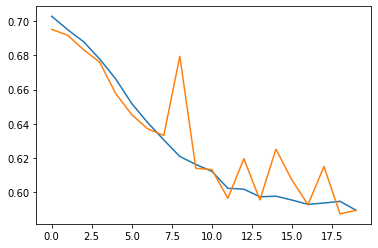

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(rn.losses)
plt.plot(rn.val_losses)
plt.show()

In [27]:
rn.score(x_val_onehot, y_val)

0.681

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN

In [33]:
model = Sequential()
model.add(SimpleRNN(32, input_shape=(414,100)))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_3 (SimpleRNN)     (None, 32)                4256      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 4,289
Trainable params: 4,289
Non-trainable params: 0
_________________________________________________________________


In [34]:
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_train_onehot, y_train, epochs=20, batch_size=32, validation_data=(x_val_onehot, y_val))

Train on 20000 samples, validate on 5000 samples
Epoch 1/20
20000/20000 [==============================] - 51s 3ms/sample - loss: 0.7014 - accuracy: 0.5235 - val_loss: 0.6836 - val_accuracy: 0.5630
Epoch 2/20
20000/20000 [==============================] - 53s 3ms/sample - loss: 0.6727 - accuracy: 0.5825 - val_loss: 0.6581 - val_accuracy: 0.6038
Epoch 3/20
20000/20000 [==============================] - 54s 3ms/sample - loss: 0.6465 - accuracy: 0.6265 - val_loss: 0.6294 - val_accuracy: 0.6460
Epoch 4/20
20000/20000 [==============================] - 52s 3ms/sample - loss: 0.6304 - accuracy: 0.6493 - val_loss: 0.6061 - val_accuracy: 0.6760
Epoch 5/20
20000/20000 [==============================] - 52s 3ms/sample - loss: 0.6160 - accuracy: 0.6648 - val_loss: 0.7877 - val_accuracy: 0.5258
Epoch 6/20
20000/20000 [==============================] - 53s 3ms/sample - loss: 0.6054 - accuracy: 0.6731 - val_loss: 0.5891 - val_accuracy: 0.6894
Epoch 7/20
20000/20000 [==============================] -

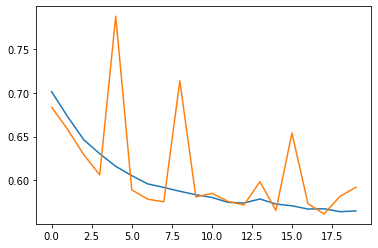

In [35]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

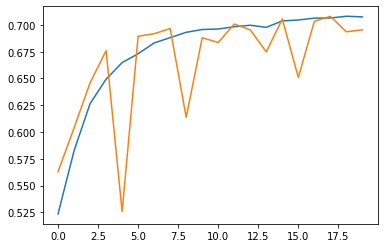

In [36]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

In [37]:
loss, accuracy = model.evaluate(x_val_onehot, y_val, verbose=0)

In [38]:
print(accuracy)

0.6954


In [39]:
from tensorflow.keras.layers import Embedding

In [40]:
(x_train_all, y_train_all), (x_test, y_test) = imdb.load_data(skip_top=20, num_words=1000)
for i in range(len(x_train_all)):
    x_train_all[i] = [w for w in x_train_all[i] if w > 2]
    
x_train = x_train_all[random_index[:20000]]
y_train = y_train_all[random_index[:20000]]
x_val = x_train_all[random_index[20000:]]
y_val = y_train_all[random_index[20000:]]

In [41]:

maxlen = 0
for i in range(len(x_train_all)):
    if maxlen < len(x_train_all[i]):
        maxlen = len(x_train_all[i])

print(maxlen)
x_train_seq = sequence.pad_sequences(x_train, maxlen=maxlen)
x_val_seq = sequence.pad_sequences(x_val, maxlen=maxlen)

862


In [42]:
model_ebd = Sequential()
model_ebd.add(Embedding(1000, 32))

In [43]:
model_ebd.add(SimpleRNN(8))
model_ebd.add(Dense(1, activation='sigmoid'))
model_ebd.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          32000     
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 8)                 328       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 32,337
Trainable params: 32,337
Non-trainable params: 0
_________________________________________________________________


In [44]:
model_ebd.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model_ebd.fit(x_train_seq, y_train, epochs=10, batch_size=32, validation_data=(x_val_seq, y_val))

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 85s 4ms/sample - loss: 0.6084 - accuracy: 0.6492 - val_loss: 0.4771 - val_accuracy: 0.7888
Epoch 2/10
20000/20000 [==============================] - 88s 4ms/sample - loss: 0.4628 - accuracy: 0.7928 - val_loss: 0.4728 - val_accuracy: 0.7826
Epoch 3/10
20000/20000 [==============================] - 82s 4ms/sample - loss: 0.4168 - accuracy: 0.8184 - val_loss: 0.4368 - val_accuracy: 0.8064
Epoch 4/10
20000/20000 [==============================] - 84s 4ms/sample - loss: 0.3792 - accuracy: 0.8403 - val_loss: 0.4318 - val_accuracy: 0.8106
Epoch 5/10
20000/20000 [==============================] - 88s 4ms/sample - loss: 0.3561 - accuracy: 0.8536 - val_loss: 0.4266 - val_accuracy: 0.8126
Epoch 6/10
20000/20000 [==============================] - 87s 4ms/sample - loss: 0.3549 - accuracy: 0.8497 - val_loss: 0.5110 - val_accuracy: 0.7450
Epoch 7/10
20000/20000 [==============================] -

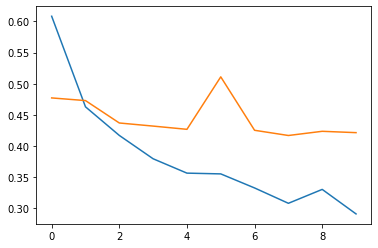

In [45]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

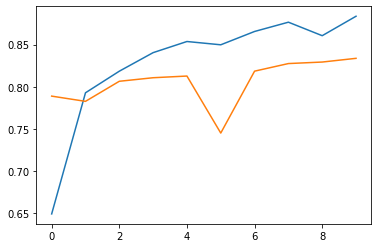

In [46]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

In [47]:

loss, accuracy = model_ebd.evaluate(x_val_seq, y_val, verbose=0)
print(accuracy)

0.8336


In [48]:
from tensorflow.keras.layers import LSTM
model_lstm = Sequential()
model_lstm.add(Embedding(1000, 32))
model_lstm.add(LSTM(8))
model_lstm.add(Dense(1, activation='sigmoid'))
model_lstm.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          32000     
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 1312      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 33,321
Trainable params: 33,321
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model_lstm.fit(x_train_seq, y_train, epochs=10, batch_size=32, validation_data=(x_val_seq, y_val))

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 150s 7ms/sample - loss: 0.4641 - accuracy: 0.7916 - val_loss: 0.3845 - val_accuracy: 0.8328
Epoch 2/10
20000/20000 [==============================] - 146s 7ms/sample - loss: 0.3354 - accuracy: 0.8626 - val_loss: 0.3577 - val_accuracy: 0.8492
Epoch 3/10
20000/20000 [==============================] - 148s 7ms/sample - loss: 0.3082 - accuracy: 0.8738 - val_loss: 0.3536 - val_accuracy: 0.8426
Epoch 4/10
20000/20000 [==============================] - 155s 8ms/sample - loss: 0.2945 - accuracy: 0.8810 - val_loss: 0.3455 - val_accuracy: 0.8492
Epoch 5/10
20000/20000 [==============================] - 152s 8ms/sample - loss: 0.2812 - accuracy: 0.8853 - val_loss: 0.3453 - val_accuracy: 0.8468
Epoch 6/10
20000/20000 [==============================] - 167s 8ms/sample - loss: 0.2694 - accuracy: 0.8898 - val_loss: 0.3574 - val_accuracy: 0.8452
Epoch 7/10
20000/20000 [===========================

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

In [ ]:

loss, accuracy = model_lstm.evaluate(x_val_seq, y_val, verbose=0)
print(accuracy)